# TINT Demonstration


This notebook will take you through the following process:

1. GET DATA - Obtain nexrad data from Amazon S3
2. GRID - Map data to cartesian grids using Py-ART
3. TRACK - Perform cell tracking using TINT
4. VISUALIZE - Visualize the tracks

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import tempfile
import os
import shutil

import pyart
from tint.data_utils import get_nexrad_keys, read_nexrad_key
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/jhemedinger/.conda/envs/precip_env/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/jhemedinger/.conda/envs/precip_env/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


## 1. GET DATA


In [2]:
# Let's get some nexrad data from Amazon S3 to use for tracking
# I know of some storm cells that passed over Houston back in July of 2015
keys = get_nexrad_keys('khgx', start='20150710_183000', end='20150710_193000')

Found 13 keys.


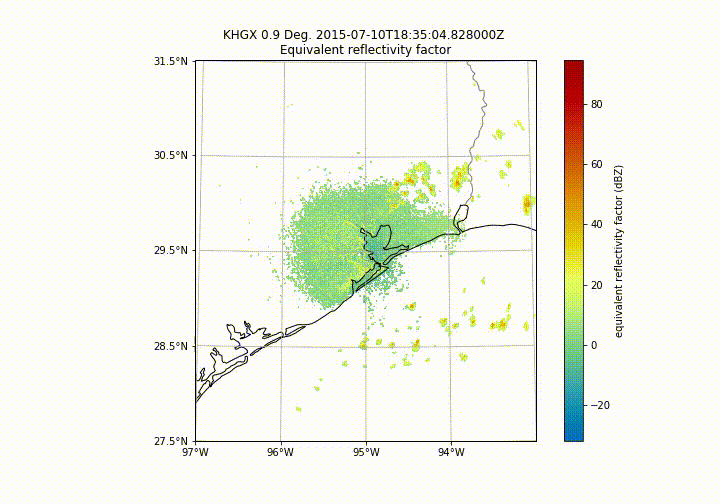

In [3]:
# We can visualize this data using pyart and matplotlib
fig = plt.figure(figsize=(10, 7))


def plot_ppi(key):
    """ Plots ppi map of nexrad data given S3 key. """
    plt.clf()
    radar = read_nexrad_key(key)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map('reflectivity', resolution='10m',
                         sweep=3, fig=fig,
                         lat_lines=np.arange(27.5, 31.6, 1),
                         lon_lines=np.arange(-97, -92.9, 1),
                         min_lon=-97, max_lon=-93, min_lat=27.5,
                         max_lat=31.5,
                         lon_0=radar.longitude['data'][0],
                         lat_0=radar.latitude['data'][0])
    del display, radar


ppi_anim = FuncAnimation(fig, plot_ppi, frames=keys, interval=1000)
tmp_anim = tempfile.NamedTemporaryFile()
ppi_anim.save(tmp_anim.name + '.mp4', writer='ffmpeg')
embed_mp4_as_gif(tmp_anim.name + '.mp4')
os.remove(tmp_anim.name + '.mp4')
plt.close()

## 2. GRID

### Disclaimer
If you are running this notebook and don't want this data to remain on your filesystem, make sure you run the last cell in the notebook. If your kernel crashes for some reason, you can manually remove the the path printed after the following cell.

In [4]:
# Looks like there are some interesting cells coming off the gulf.
# Let's make a function that maps these volumes to cartesian grids using pyart.
# Most of the cells seem to be in the bottom right quadrant, so we'll only grid
# that part of the domain to save time.

def get_grid(radar):
    """ Returns grid object from radar object. """
    grid = pyart.map.grid_from_radars(
        radar, grid_shape=(31, 401, 401),
        grid_limits=((0, 15000), (-200000, 0), (0, 200000)),
        fields=['reflectivity'], gridding_algo='map_gates_to_grid',
        h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid


# Let's write these grids to a temporary location so that we can reuse them.
# This might take a few minutes
tmp_dir = tempfile.mkdtemp()
print('temporary directory:', tmp_dir)
filenames = []
for num, key in enumerate(keys):
    print('saving grid', num)
    radar = read_nexrad_key(key)
    grid = get_grid(radar)
    name = os.path.join(tmp_dir, 'grid_' + str(num).zfill(3) + '.nc')
    filenames.append(name)
    pyart.io.write_grid(name, grid)
    del radar, grid

temporary directory: /tmp/tmpxv1dvnal
saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9
saving grid 10
saving grid 11
saving grid 12


In [5]:
# Now we can easily instantiate generators of these grids like so
grids = (pyart.io.read_grid(fn) for fn in filenames)

## 3. TRACK

In [6]:
# First, let's instantiate a tracks object and view the default parameters
tracks_obj = Cell_tracks()
tracks_obj.params

{'FIELD_THRESH': 32,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000,
 'FLOW_MARGIN': 10000,
 'MAX_FLOW_MAG': 50,
 'MAX_DISPARITY': 999,
 'MAX_SHIFT_DISP': 15,
 'ISO_THRESH': 8,
 'ISO_SMOOTH': 3,
 'GS_ALT': 1500}

In [7]:
# The cells we're interested in look a bit small. Let's reduce the minimum size threshold.
tracks_obj.params['MIN_SIZE'] = 4
# We'll give the generator of grids we made earlier to the get_tracks method of our tracks object.
tracks_obj.get_tracks(grids)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9
Writing tracks for scan 10
Writing tracks for scan 11
Writing tracks for scan 12


time elapsed 0.2 minutes


In [8]:
# Now we can view the 'tracks' attribute of our tracks object to see the results.
tracks_obj.tracks.head(20)

time   grid_x   grid_y      lon      lat   area  \
scan uid                                                                  
0    0   2015-07-10 18:34:06  243.176  160.294 -93.8368  28.3870   8.50   
     1   2015-07-10 18:34:06    9.353  186.588 -95.0327  28.5141  12.75   
     2   2015-07-10 18:34:06  132.832  191.434 -94.3981  28.5304  28.25   
     3   2015-07-10 18:34:06   75.346  189.423 -94.6949  28.5226   6.50   
     4   2015-07-10 18:34:06  333.875  235.005 -93.3662  28.7190  54.00   
     5   2015-07-10 18:34:06  388.000  232.674 -93.0895  28.7062  23.00   
     6   2015-07-10 18:34:06  310.732  233.744 -93.4842  28.7160  20.50   
     7   2015-07-10 18:34:06  223.622  233.541 -93.9302  28.7205   9.25   
     8   2015-07-10 18:34:06  265.609  240.848 -93.7145  28.7500  11.50   
     9   2015-07-10 18:34:06  198.780  244.732 -94.0579  28.7710  10.25   
     10  2015-07-10 18:34:06  263.294  251.529 -93.7292  28.7996   4.25   
     11  2015-07-10 18:34:06  346.455  253.364 -93.3033  28.7991   5.50   
     12  2015-07-10 18:34:06  348.067  275.233 -93.2913  28.8979  15.00   
     13  2015-07-10 18:34:06  122.400  278.046 -94.4520  28.9218  16.25   
     14  2015-07-10 18:34:06  289.824  339.000 -93.5850  29.1893   4.25   
1    15  2015-07-10 18:38:24  105.278  150.500 -94.5423  28.3467   4.50   
     16  2015-07-10 18:38:24  157.741  154.519 -94.2714  28.3678   6.75   
     0   2015-07-10 18:38:24  241.517  161.793 -93.8418  28.3960   7.25   
     1   2015-07-10 18:38:24    7.273  187.727 -95.0429  28.5186   8.25   
     2   2015-07-10 18:38:24  131.445  192.571 -94.4082  28.5394  29.75   

              vol        max  max_alt  isolated  
scan uid                                         
0    0     15.500  42.666897      4.5      True  
     1     33.500  41.691845      4.0     False  
     2     92.875  49.863453      5.5     False  
     3     11.000  41.088463      3.5      True  
     4    164.125  47.321510      7.0     False  
     5     34.500  42.496269      5.5      True  
     6     59.375  48.063271      6.0     False  
     7     30.500  45.998184      6.5     False  
     8     33.000  47.990311      6.0     False  
     9     23.875  47.172359      4.5      True  
     10     3.000  35.878979      2.5     False  
     11     3.500  37.381557      2.5     False  
     12    27.625  42.841183      4.5     False  
     13    49.625  49.762157      5.5      True  
     14     7.750  38.055103      3.5      True  
1    15     9.125  44.994991      4.0      True  
     16    11.500  39.081177      4.0      True  
     0     12.125  41.356445      4.5     False  
     1     17.125  39.393597      4.0     False  
     2     89.000  50.227497      5.0     False

## 4. VISUALIZE

In [9]:
# We can visualize these tracks to assess the performance of the algorithm.
# First we need to make another generator of the same grids for the animator
grids = (pyart.io.read_grid(fn) for fn in filenames)

In [10]:
# Let's save the animation in our temp directory so that it will be cleaned up later.
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_anim'),
        lat_lines=np.arange(27.9, 29.5, .5),
        lon_lines=np.arange(-95, -92.9, .5),
        tracers=True)

Animating 13 frames
Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12


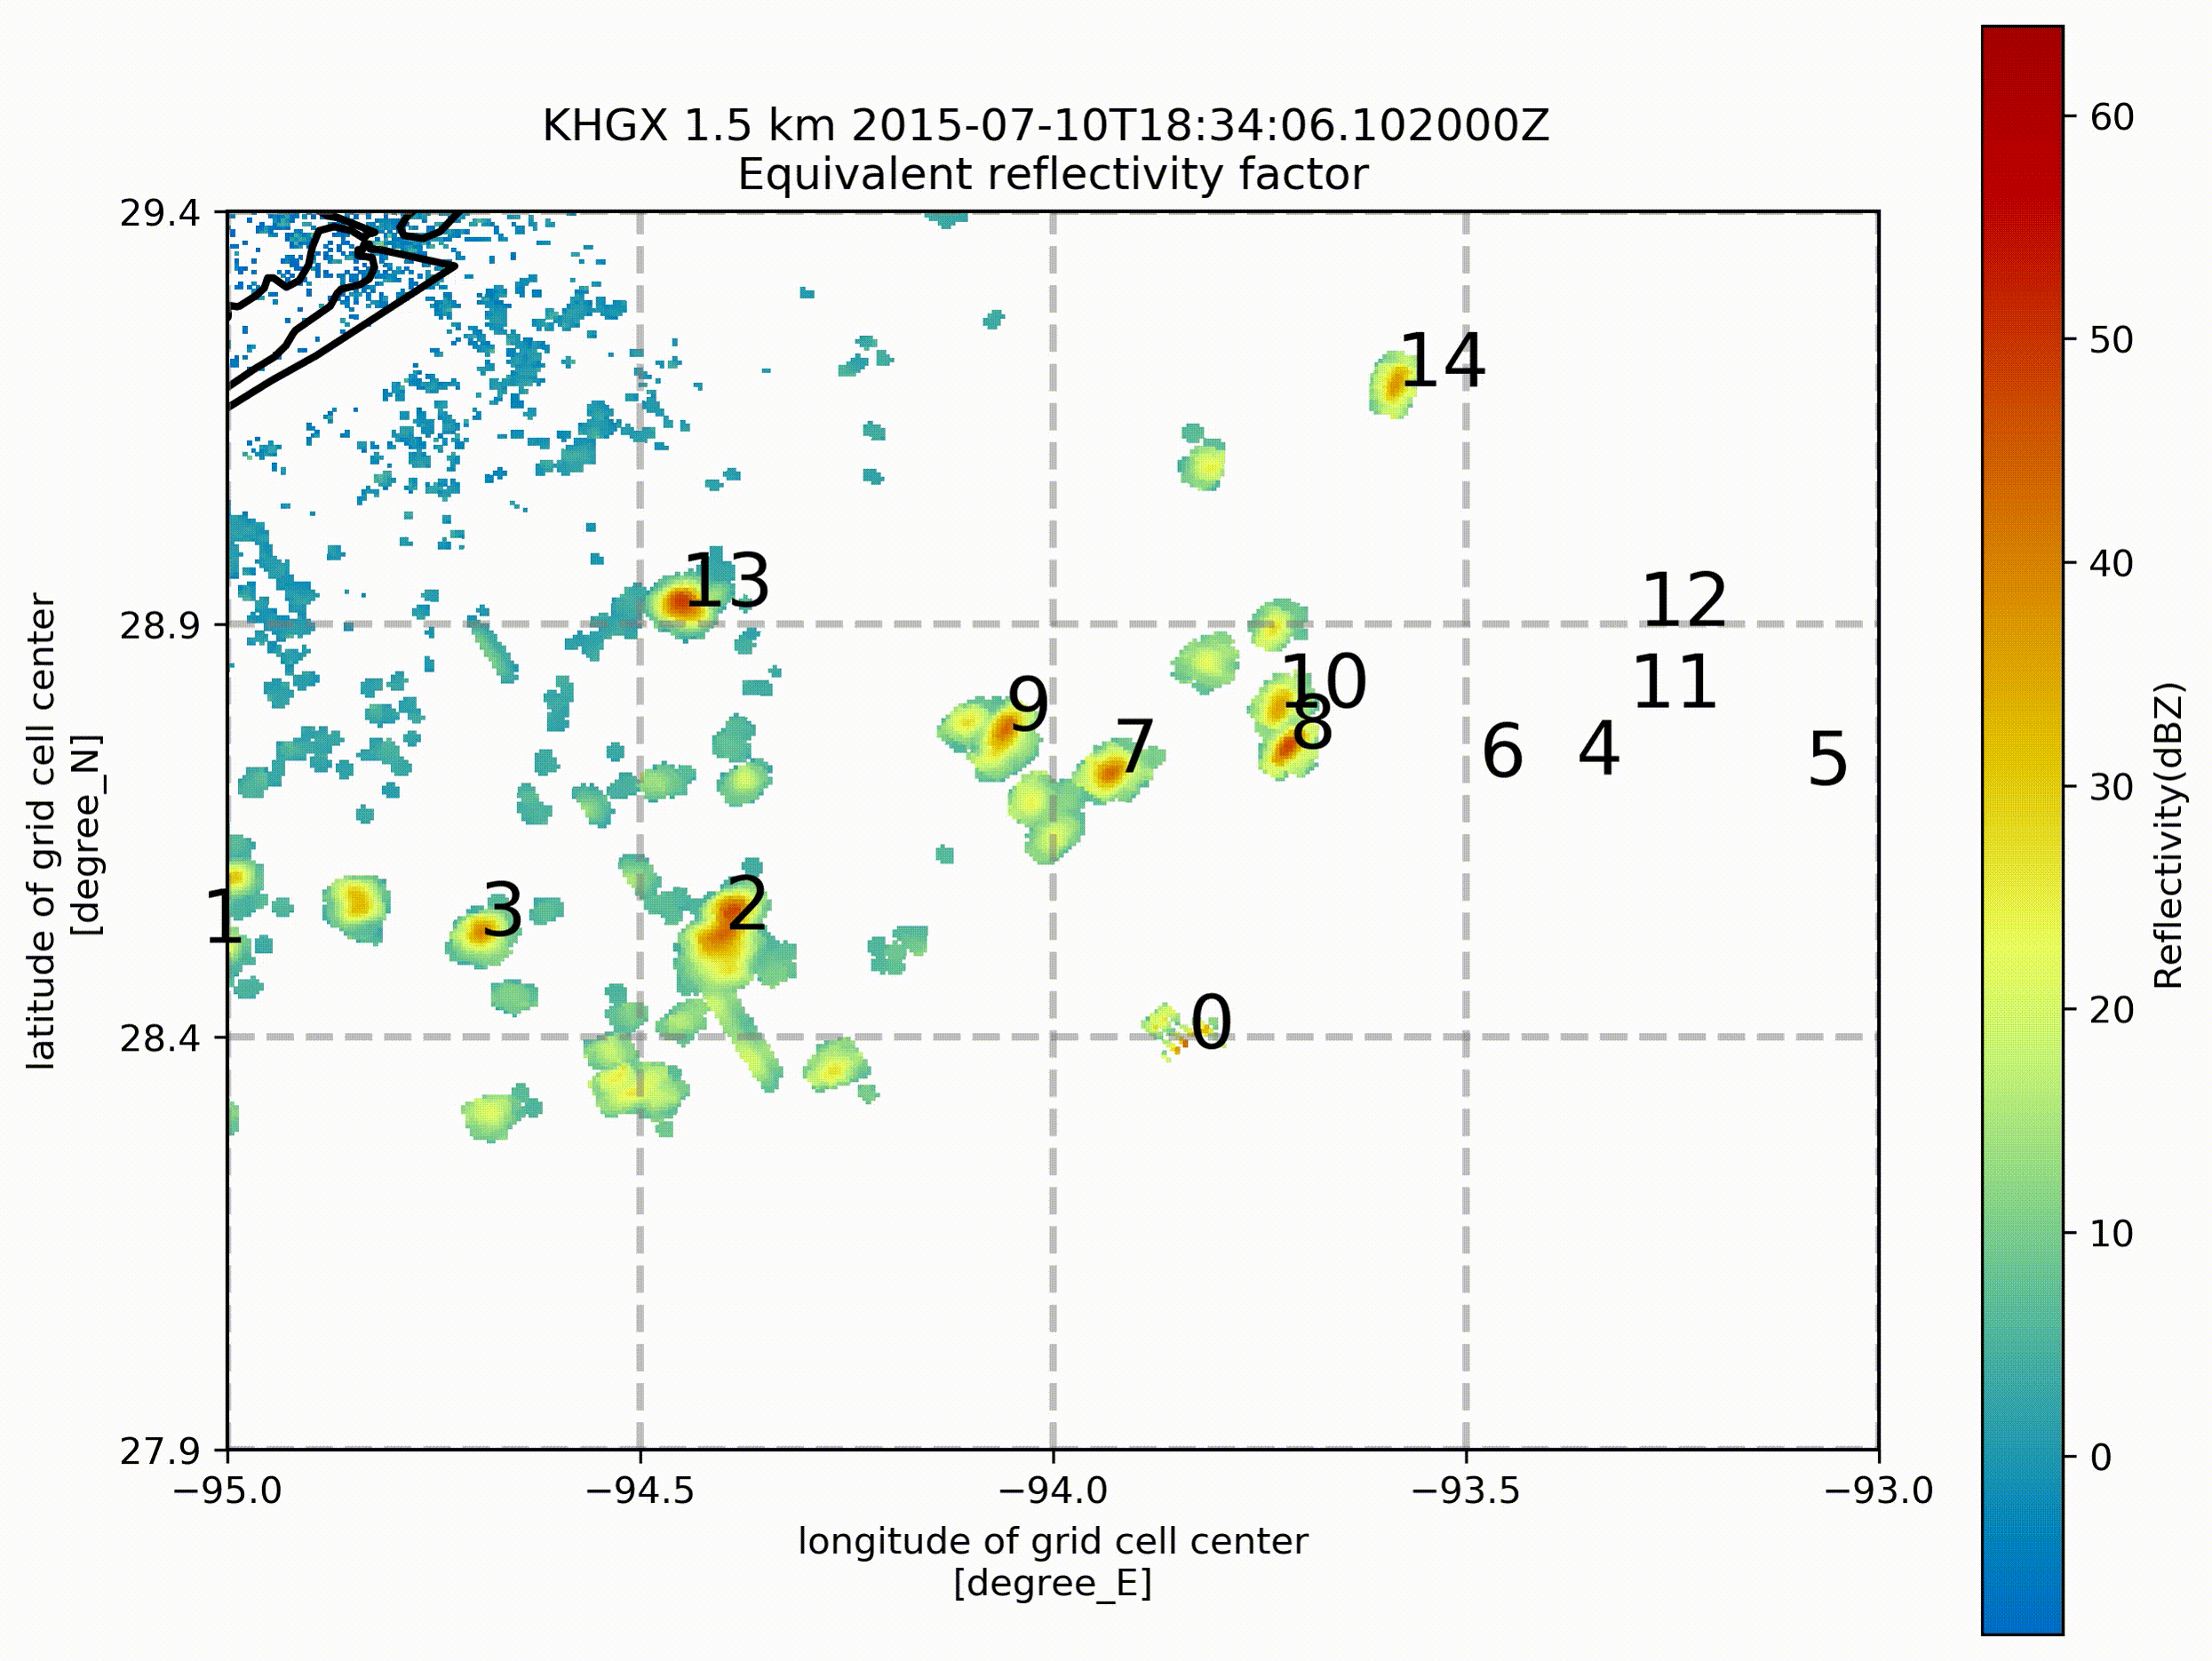

In [11]:
# The animator saved an mp4 to our local directory. Now we can embed it as a gif in this notebook.
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_anim.mp4'))

In [12]:
# Let's find the cells that were tracked for the most frames
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:5]

uid
0     13
3     13
4     13
16    12
19    10
dtype: int64

In [13]:
# Now we can view these cells from a lagrangian perspective
grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_lagrangian'), style='lagrangian', uid='0', alt=2000)

Animating 13 frames
Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12


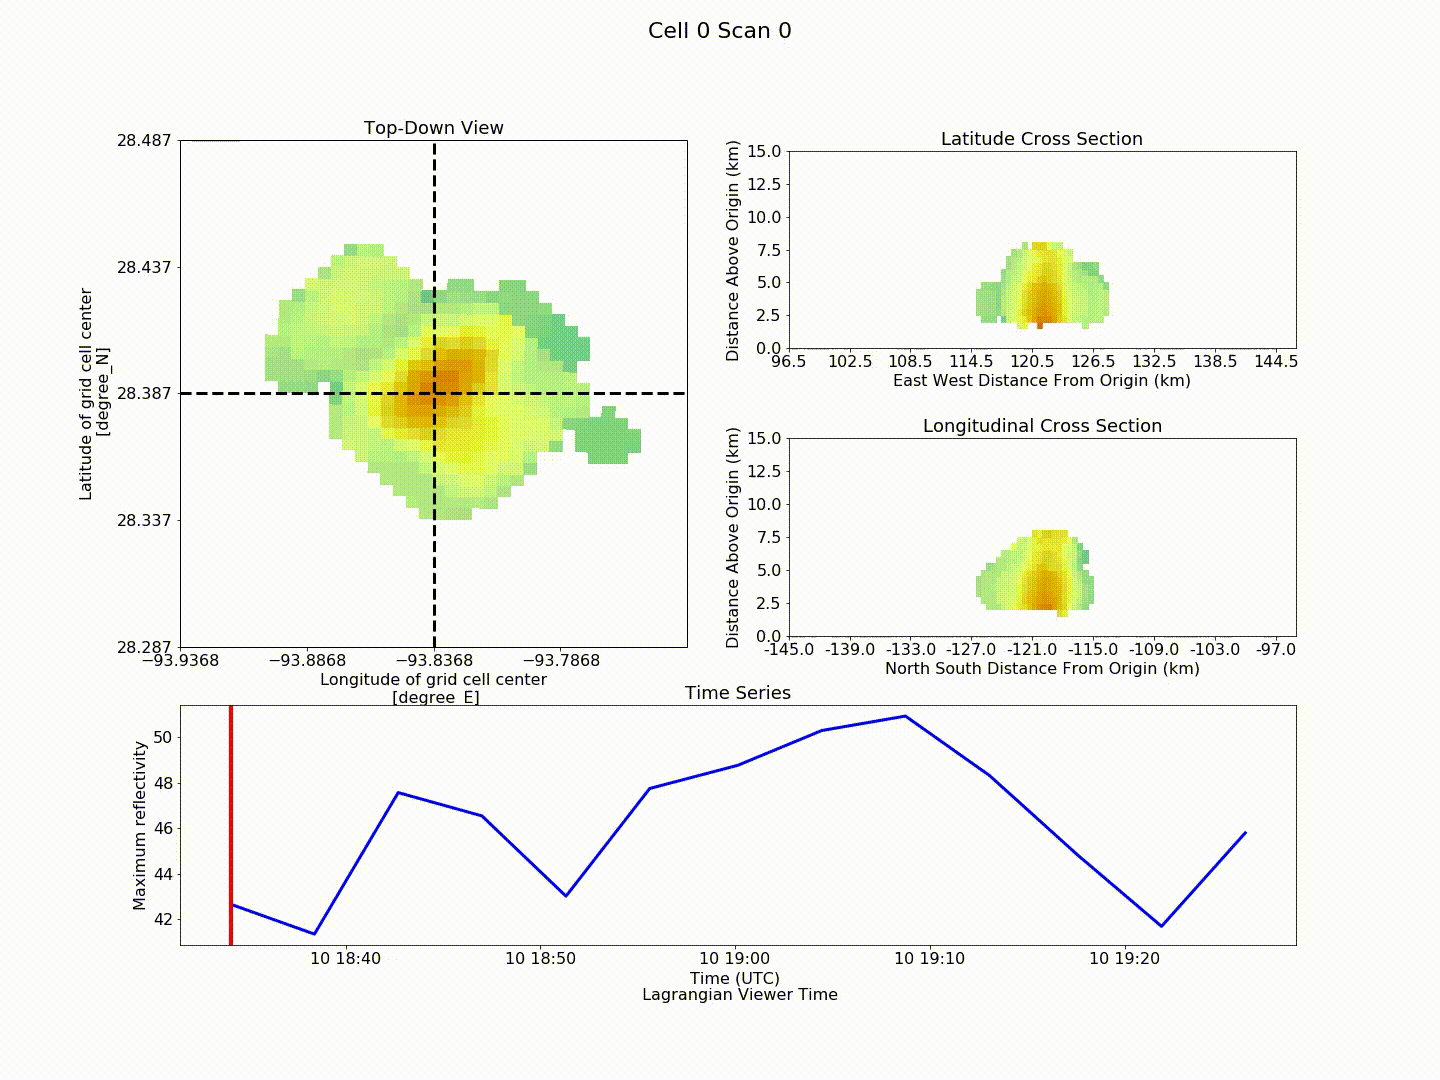

In [14]:
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_lagrangian.mp4'))

In [15]:
# We can view the attributes of this cell throughout its lifetime
tracks_obj.tracks.xs('0', level='uid')

,time,grid_x,grid_y,lon,lat,area,vol,max,max_alt,isolated
scan,,,,,,,,,,
0,2015-07-10 18:34:06,243.176,160.294,-93.8368,28.3870,8.50,15.500,42.666897,4.5,True
1,2015-07-10 18:38:24,241.517,161.793,-93.8418,28.3960,7.25,12.125,41.356445,4.5,False
2,2015-07-10 18:42:42,234.281,169.439,-93.8823,28.4278,14.25,34.250,47.569725,4.5,True
3,2015-07-10 18:47:00,232.862,169.379,-93.8874,28.4279,14.50,37.000,46.546478,4.5,True
4,2015-07-10 18:51:19,230.814,170.017,-93.8976,28.4325,14.75,30.125,43.021236,4.5,True
5,2015-07-10 18:55:37,228.106,172.176,-93.9128,28.4416,21.25,52.625,47.750183,5.0,True
6,2015-07-10 19:00:09,225.377,174.316,-93.9281,28.4507,28.50,79.750,48.770615,5.5,True
7,2015-07-10 19:04:27,222.928,176.775,-93.9381,28.4643,27.75,85.375,50.295033,6.5,True
8,2015-07-10 19:08:45,220.943,179.105,-93.9483,28.4734,26.25,92.000,50.929760,7.0,True


## Clean Up

In [16]:
# Now we can delete the directory containing all the data and output from this demo.
shutil.rmtree(tmp_dir)
print('temporary directory removed')

temporary directory removed
